# HMC gradient model 2D

Conceptual setup of Hamiltonian Monte Carlo with a derivGP as a surrogate for gradients.
The notebook contains

1. A 2d test function
2. plots from actual HMC
3. a simple training procedure for a surrogate 

In [23]:
import numpy as np
import scipy.linalg as slinalg

import matplotlib.pyplot as plt
from hamiltonian_mc import HamiltonianMonteCarlo, GPGradientHMC
from utils import plot_matrices

plt.style.use("icml21.mplstyle")

## 1. A 2d test function

$$ f(x_1, x_2) = \exp \left(- \frac{1}{2} \left(x_1^2 + (a_1 x_1^2 + a_2 x_2 + a_3)^2 \right)\right) $$

In [24]:
aa = [2., 2., -2.]

def x_trafo(x):
    xnew = x.copy()
    if xnew.ndim == 1:
        xnew = xnew[:, None]
    xnew[1,:] = aa[0]*xnew[0,:]**2 + aa[1]*xnew[1,:] + aa[2]
    return xnew

def fun2d(x):
    "Some unnormalized density"
    arg = x_trafo(x)
    return np.exp(-0.5*(arg**2).sum(axis=0)).squeeze()

def E2d(x):
    "The negative log of the above, that is, the potential energy"
    return -np.log(fun2d(x))

def grad_E2d(x):
    xnew = x_trafo(x)
    grad = np.zeros_like(xnew)
    grad[0, :] = xnew[0, :] + xnew[1, :] * 2 * x[0, :] * aa[0]
    grad[1, :] = xnew[1, :] * aa[1]
    return grad

In [25]:
np.random.seed(42)
dim = 2
x0 = np.random.randn(dim, 1)

## 2. Plain HMC

In [26]:
hmc = HamiltonianMonteCarlo(E2d, grad_E2d, 10, 3.e-2)
X_hmc = hmc.sample(100, x0)

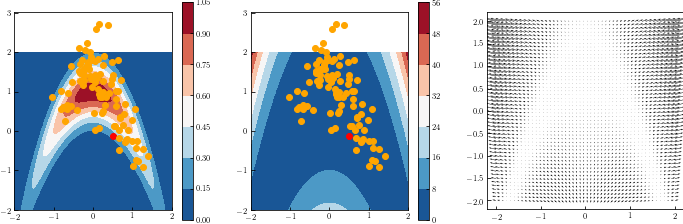

In [27]:
N_plot = 50

x_plot = np.linspace(-2.,2.,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=0)).reshape(dim, -1)


fig, ax = plt.subplots(1, 3, figsize=(12,4))
functions = [fun2d, E2d]
for i in range(2):
    cpl = ax[i].contourf(X1, X2, functions[i](X).reshape(N_plot, N_plot))
    ax[i].set_aspect('equal')
    ax[i].scatter(x0[0],x0[1], c='red')
    ax[i].scatter(X_hmc[:,0],X_hmc[:,1], c='orange')
    plt.colorbar(cpl, ax=ax[i])

gradE = grad_E2d(X)
ax[2].quiver(X1, X2, gradE[0,:].reshape(N_plot, N_plot), gradE[1,:].reshape(N_plot, N_plot), scale=1.e3)
ax[2].set_aspect('equal')

## 3. Hamiltonian Monte Carlo with gradient surrogate

In [6]:
import sys

sys.path.append('../src')
from inference import DerivativeGaussianProcess
from kernels import RBF

In [19]:
kern = RBF(dim, 2.)
gp = DerivativeGaussianProcess(kern)

gpg_hmc = GPGradientHMC(E2d, grad_E2d, gp, 10, 4.e-2, N_train=25, N_burn=10)

Sample from objective, including training

In [20]:
np.random.seed(42) # fix same random sequence as above
x0 = np.random.randn(dim, 1)

X_gph = gpg_hmc.sample(200, x0)

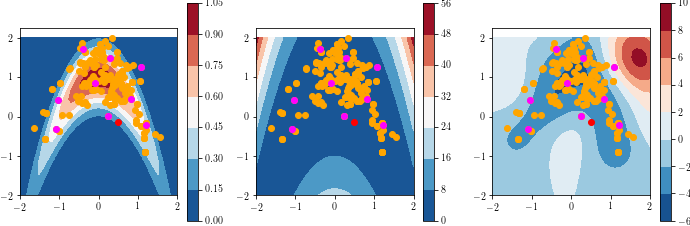

In [21]:
N_plot = 50

x_plot = np.linspace(-2.,2.,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=0)).reshape(dim, -1)


fig, ax = plt.subplots(1, 3, figsize=(12,4))
functions = [fun2d, E2d, gp.infer_f]
for i in range(3):
    cpl = ax[i].contourf(X1, X2, functions[i](X).reshape(N_plot, N_plot))
    ax[i].set_aspect('equal')
    ax[i].scatter(x0[0],x0[1], c='red')
    ax[i].scatter(X_gph[:,0],X_gph[:,1], c='orange')
    ax[i].scatter(gp.data['dX'][0,:], gp.data['dX'][1,:], c='magenta')
    plt.colorbar(cpl, ax=ax[i])

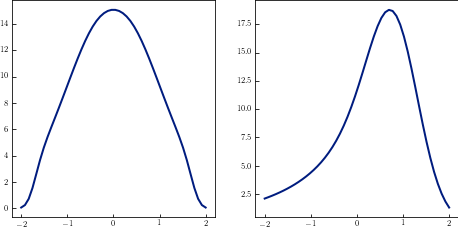

In [28]:
## Plot the marginals
fig, ax = plt.subplots(1, 2, figsize=(8,4))
fplot = fun2d(X).reshape(N_plot, N_plot)
ax[0].plot(x_plot, fplot.sum(axis=1))
ax[1].plot(x_plot, fplot.sum(axis=0))

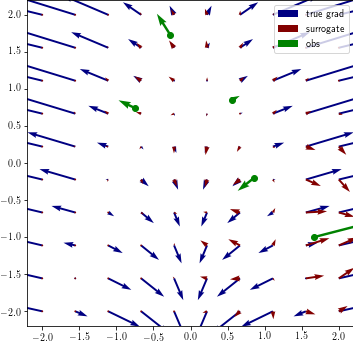

In [11]:
## Examine gradients, true and predicted gradient field
fig, ax = plt.subplots(1, 1, figsize=(6,6))

x_plot = np.linspace(-2,2,10)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
Xsub = (np.stack([X1, X2], axis=0)).reshape(dim, -1)
gradE = grad_E2d(Xsub)
gp_gE = gp.infer_g(Xsub)

labels=['true grad', 'surrogate']
    
for i,g in enumerate([gradE, gp_gE]):
    ax.quiver(Xsub[0,:], Xsub[1,:], g[0,:], g[1,:], scale=150, color='C'+str(i), label=labels[i])
ax.quiver(gp.data['dX'][0,:], gp.data['dX'][1,:], gp.data['dY'][0,:], gp.data['dY'][1,:], scale=50, color='C2', label='obs')
ax.scatter(gp.data['dX'][0,:], gp.data['dX'][1,:], color='C2')
ax.set_aspect('equal')
ax.legend(loc=1)
plt.show()
# norm_gE = np.sqrt((gradE**2).sum(axis=0, keepdims=True))


## BACKUP (old stuff with manually implemented gradient inference)

In [37]:
class ExponentiatedQuadraticKernel:
    def __init__(self, lengthscale, variance):
        self.lengthscale = lengthscale
        self.variance = variance
        
    def k(self, x1, x2=None):
        if x2 is None:
            x2 = x1
        dist = ((x1[:, None, :] - x2[None, :, :])**2).sum(axis=-1)/self.lengthscale**2
        return np.exp(- 0.5*dist)
    
#     def dk(self, x1, x2=None):
#         if x2 is None:
#             x2 = x1
#         dim = x1.shape[1]
#         K = self.k(x1, x2)
#         dK = np.zeros((x1.size, x2.shape[0]))
#         for i, x1i in enumerate(x1):
#             for j, x2j in enumerate(x2):
#                 dK[i*dim:(i+1)*dim, j] = (x1i - x2j) * K[i,j]/self.lengthscale**2
#         return dK
    
    def dk(self, x1, x2=None):
        if x2 is None:
            x2 = x1
        dim = x1.shape[1]
        K_inflated = np.kron(self.k(x1, x2), np.ones((dim,1)))
        X = (x1.T[:, :, None] - x2.T[:, None, :]).reshape(x1.size, x2.shape[0], order='f')
        return K_inflated * X / self.lengthscale**2
    
    def dkd(self, x1, x2=None):
        if x2 is None:
            x2 = x1
        dim = x1.shape[1]
        K = self.k(x1, x2)
        dK = np.zeros((x1.size, x2.size))
        for i, x1i in enumerate(x1):
            for j, x2j in enumerate(x2):
                dK[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = - np.outer((x1i - x2j), (x1i - x2j)) * K[i,j]/self.lengthscale**4 + K[i,j]*np.eye(dim)/self.lengthscale**2
        return dK
    

class DerivativeGPInference:
    """
    Inference from noise-free gradient observations on gradients.
    Currently does not include function evaluations.
    Static: all data given a priori
    zero prior mean
    """
    def __init__(self, X, dY, dkernel):
        self.X = X
        self.dY = dY.reshape(-1,1)
        self.kern = dkernel
        
        K = self.kern.dkd(X) + np.eye(dY.size) * 1.e-6
        self.L = slinalg.cho_factor(K)
        
    def infer(self, x):
        """
        Compute posterior mean and covariance (assuming noise-free evaluations)
        """
        k = self.kern.dkd(self.X,x)
        Kinv_k = slinalg.cho_solve(self.L, k)
        kT_Kinv_k = k.T @ Kinv_k
        
        post_grad_mean = Kinv_k.T @ self.dY
        post_grad_var = self.kern.dkd(x,x) - kT_Kinv_k
        
        return post_grad_mean, post_grad_var        

Checking the kernel and the inference procedure

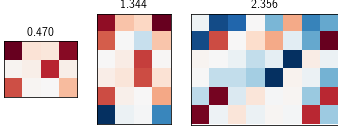

In [38]:
np.random.seed(0)
x1 = np.random.randn(3, dim)*0.5
x2 = np.random.randn(4, dim)*0.5

kern = ExponentiatedQuadraticKernel(0.4, 5.)
plot_matrices([kern.k(x1, x2), kern.dk(x1, x2), kern.dkd(x1, x2)])

In [39]:
# Condition GP on gradients at some of the locations found by HMC
X_hmc = np.random.permutation(np.unique(X_hmc, axis=0))
X_dat = X_hmc[:10,:]
dE_dat = grad_E2d(X_dat)

X_test = X_hmc[10:,:]
dE_test = grad_E2d(X_test)

In [40]:
dgp = DerivativeGPInference(X_dat, dE_dat, kern)

dm, dv = dgp.infer(X_test)

In [42]:
dM = dm.reshape(-1, dim)

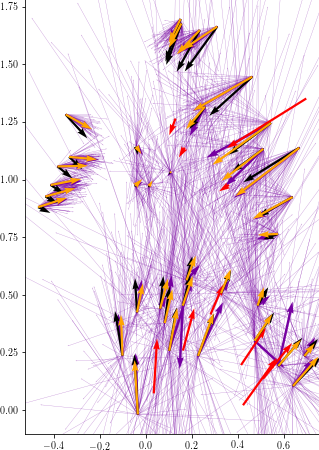

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

vec_scale = 20

# sample a few vectors for each prediction (to see uncertainty)
num_sam = 50
for i in range(dm.size//dim):
    L_i = slinalg.cholesky(dv[dim*i: dim*(i+1), dim*i: dim*(i+1)], lower=True)
    m_i = dm[dim*i: dim*(i+1)]
    samples = m_i.T + slinalg.solve_triangular(L_i, np.random.randn(dim, num_sam), lower=True).T
    ax.quiver(X_test[i,0], X_test[i,1], samples[:,0], samples[:,1], scale=vec_scale, color='C4', width=1.e-3, alpha=0.5)
    
    empirical_mean = samples.sum(axis=0)/num_sam
    ax.quiver(X_test[i,0], X_test[i,1], empirical_mean[0], empirical_mean[1], scale=vec_scale, color='C4', width=8.e-3)

ax.quiver(X_dat[:,0], X_dat[:,1], dE_dat[:,0], dE_dat[:,1], scale=vec_scale, color='red')
ax.quiver(X_test[:,0], X_test[:,1], dE_test[:,0], dE_test[:,1], scale=vec_scale, color='k')
ax.quiver(X_test[:,0], X_test[:,1], dm[::2], dm[1::2], scale=vec_scale, color='orange')

ax.set_aspect('equal')

### Hamiltonian Monte Carlo with Gradient GP
Rough algorithmus:
- burn-in HMC
- GP training
- run HMC with GP, update gradient surrogate _if necessary_ (tbd)

In [48]:
def g_mean(x):
    if x.ndim == 1:
        x = x[None,:]
    return dgp.infer(x)[0].squeeze()

In [62]:
X_gphmc = HamiltonianMC(E2d, g_mean, 100, 22, 3.e-2, x0)

(200,) (100, 2)


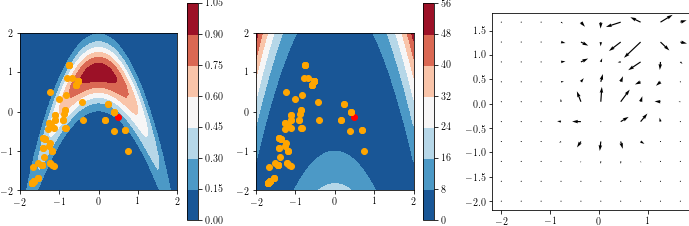

In [63]:
N_plot = 50

x_plot = np.linspace(-2.,2.,N_plot)
X1, X2 = np.meshgrid(x_plot, x_plot, indexing='ij')
X = (np.stack([X1, X2], axis=-1)).reshape(-1,dim)


fig, ax = plt.subplots(1, 3, figsize=(12,4))
functions = [fun2d, E2d]
for i in range(2):
    cpl = ax[i].contourf(X1, X2, functions[i](X).reshape(N_plot, N_plot))
    ax[i].set_aspect('equal')
    ax[i].scatter(x0[0],x0[1], c='red')
    ax[i].scatter(X_gphmc[:,0],X_gphmc[:,1], c='orange')
    plt.colorbar(cpl, ax=ax[i])

Xsub = (np.stack([X1[::5,::5], X2[::5,::5]], axis=-1)).reshape(-1,dim)
gradE = g_mean(Xsub)
print(gradE.shape, Xsub.shape)
ax[2].quiver(Xsub[:,0], Xsub[:,1], gradE[::2], gradE[1::2], scale=50)
ax[2].set_aspect('equal')

#### Up next:

- consider higher dimensional example -> What are acceptance rates? 
- when to re-evaluate and condition on the gradient? 
    - According to acceptance probability? That would be at the end of leapfrog steps only.
    - If during leapfrog: Use uncertainty somehow?
        - Technically during leapfrog doesn't matter. If the gradient is wrong, it only causes trouble if the energy _increases_. Need to understand what that means...
- **Baselines:** NNgHMC
     
**Other notes**
- normalize data, so HMC parameters remain similar.
- model of the gradient should be sufficient, but maybe accuracy increases if conditioning on the function values also.